# Distinción de velocidades segun hora

En este codigo distinguira las velocidades segun la hora

## Necesarios
* Librerias instaladas en especial Geopandas
* Velocidades calibradas

In [1]:
# Tratamiento de datos
# ==============================================================================
import gpxpy 
import gpxpy.gpx
import pandas as pd
import numpy as np
import geopandas as gp

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, time, date
from os import listdir
import os
import re
from shapely.geometry import Point, LineString
from shapely import wkt

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Se cargan los puntos de velocidad que se usaran
velocidades = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/Carro.shp")
velocidadesm = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/Moto.shp")
velocidadesb = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/Bici.shp")
velocidadest = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/TPC.shp")

In [3]:
#Segun la columna de tiempo calcula el entero de segundos definiendo una funcion
def time_to_num(time_str):
    hh, mm , ss = map(int, time_str.split(':'))
    return ss + 60*(mm + 60*hh)

## Carro

In [4]:
#calcular los segundos a partir de la función definida
velocidades['sec'] = velocidades.apply(
    lambda row: time_to_num(
        time_str=row['tiempo']
    ),
    axis=1
)

In [5]:
#Se visualiza los datos para ver el calculo
velocidades.head(6)

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,angulo_vel,geometry,sec
0,EO,3,1010.00000,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,20-06-2017,06:00:00,06:38:43,170.58524,POINT (883647.110 984840.929),23923
1,EO,4,966.00000,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,20-06-2017,06:00:00,06:38:58,171.92208,POINT (883652.613 984807.741),23938
2,EO,5,946.00000,4.44444,16.00000,2017-06-20 06:39:11,4.45760,-75.12570,20-06-2017,06:00:00,06:39:11,184.49619,POINT (883659.940 984756.117),23951
3,EO,6,937.00000,6.11111,22.00000,2017-06-20 06:39:16,4.45738,-75.12572,20-06-2017,06:00:00,06:39:16,212.91184,POINT (883658.056 984732.157),23956
4,EO,7,935.00000,6.66667,24.00000,2017-06-20 06:39:21,4.45715,-75.12587,20-06-2017,06:00:00,06:39:21,232.40697,POINT (883641.368 984706.374),23961
5,EO,8,935.00000,4.72222,17.00000,2017-06-20 06:39:35,4.45663,-75.12653,20-06-2017,06:00:00,06:39:35,225.18605,POINT (883567.285 984649.336),23975


In [6]:
#Se calculan los datos de minutos y segundos 
velocidades["min"] = (velocidades["sec"] /60)
velocidades["hr"] = (velocidades["min"] /60)

In [7]:
#Se visualiza la tabla para chequear valores
velocidades

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,fecha,t0,tiempo,angulo_vel,geometry,sec,min,hr
0,EO,3,1010.00000,2.22222,8.00000,2017-06-20 06:38:43,4.45837,-75.12582,20-06-2017,06:00:00,06:38:43,170.58524,POINT (883647.110 984840.929),23923,398.71667,6.64528
1,EO,4,966.00000,3.88889,14.00000,2017-06-20 06:38:58,4.45807,-75.12577,20-06-2017,06:00:00,06:38:58,171.92208,POINT (883652.613 984807.741),23938,398.96667,6.64944
2,EO,5,946.00000,4.44444,16.00000,2017-06-20 06:39:11,4.45760,-75.12570,20-06-2017,06:00:00,06:39:11,184.49619,POINT (883659.940 984756.117),23951,399.18333,6.65306
3,EO,6,937.00000,6.11111,22.00000,2017-06-20 06:39:16,4.45738,-75.12572,20-06-2017,06:00:00,06:39:16,212.91184,POINT (883658.056 984732.157),23956,399.26667,6.65444
4,EO,7,935.00000,6.66667,24.00000,2017-06-20 06:39:21,4.45715,-75.12587,20-06-2017,06:00:00,06:39:21,232.40697,POINT (883641.368 984706.374),23961,399.35000,6.65583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147073,2021-06-28_09-32_Mon.gpx,197447,1142.90000,0.73675,2.65231,2021-06-28 15:04:36,4.44815,-75.19987,28-06-2021,15:04:34,15:04:36,136.84720,POINT (875425.195 983723.575),54276,904.60000,15.07667
147074,2021-06-28_09-32_Mon.gpx,197448,1142.90000,0.60313,2.17125,2021-06-28 15:04:37,4.44815,-75.19986,28-06-2021,15:04:36,15:04:37,40.93390,POINT (875425.772 983722.961),54277,904.61667,15.07694
147075,2021-06-28_09-32_Mon.gpx,197449,1142.90000,0.98733,3.55439,2021-06-28 15:04:39,4.44817,-75.19985,28-06-2021,15:04:37,15:04:39,15.89877,POINT (875426.567 983723.877),54279,904.65000,15.07750
147076,2021-06-28_09-32_Mon.gpx,197450,1142.00000,0.49637,1.78694,2021-06-28 15:04:41,4.44817,-75.19985,28-06-2021,15:04:39,15:04:41,335.38397,POINT (875426.946 983725.210),54281,904.68333,15.07806


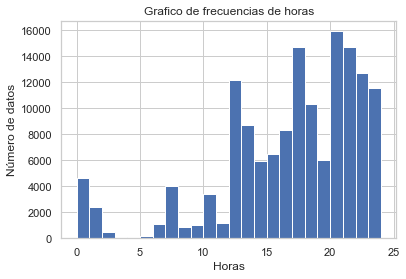

In [8]:
#Una vez obtenidos los datos se construye un histograma para visualizar el número de datos segun la hora definida
n_group = 24
#Definición del histograma
hist, bin_edges = np.histogram(velocidades["hr"], n_group)
plt.hist(velocidades["hr"], bins=bin_edges)
plt.xlabel("Horas")
plt.ylabel("Número de datos")
plt.title("Grafico de frecuencias de horas")
#plt.show()
plt.savefig("C:/Users/user/Desktop/Tesis/Figuras/07HistGranjas.png", dpi = 300)

In [9]:
#Obtener rangos pico y valle segun los definidos para la ciudad
velocidades["pico_valle"] =0
for i in range(len(velocidades)):
    if (velocidades["hr"].iloc[i] >= 7.25) & (velocidades["hr"].iloc[i] <= 8.25):
        velocidades["pico_valle"].iloc[i] = "pico1"
    elif (velocidades["hr"].iloc[i] >= 10.5) & (velocidades["hr"].iloc[i] <= 11.5):
        velocidades["pico_valle"].iloc[i] = "valle1"
    elif (velocidades["hr"].iloc[i] >= 11.75) & (velocidades["hr"].iloc[i] <= 12.75):
        velocidades["pico_valle"].iloc[i] = "pico2"
    elif (velocidades["hr"].iloc[i] >= 12.75) & (velocidades["hr"].iloc[i] <= 13.75):
        velocidades["pico_valle"].iloc[i] = "valle2"
    elif (velocidades["hr"].iloc[i] >= 13.75) & (velocidades["hr"].iloc[i] <= 14.75):
        velocidades["pico_valle"].iloc[i] = "pico3"
    elif (velocidades["hr"].iloc[i] >= 15.25) & (velocidades["hr"].iloc[i] <= 16.25):
        velocidades["pico_valle"].iloc[i] = "valle3"
    elif (velocidades["hr"].iloc[i] >= 17.75) & (velocidades["hr"].iloc[i] <= 18.75):
        velocidades["pico_valle"].iloc[i] = "pico4"
    elif (velocidades["hr"].iloc[i] >= 19.75) & (velocidades["hr"].iloc[i] <= 20.45):
        velocidades["pico_valle"].iloc[i] = "valle4"

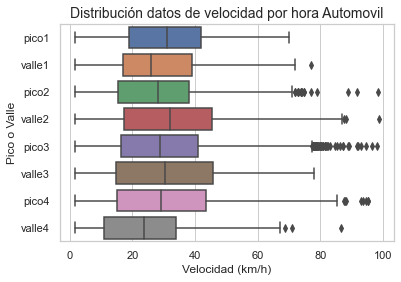

In [17]:
#Se realiza el boxplot de las velocidades en carro de la RED teniendo en cuenta la franja horaria de estas
#boxplot = sns.boxplot(y=velocidades["pico_valle"], x=velocidades["velocity_k"])
boxplot = sns.boxplot(y=velocidades["pico_valle"], x=velocidades["velocity_k"],
                      order=["pico1", "valle1", "pico2", "valle2", "pico3", "valle3", "pico4", "valle4"])
boxplot.axes.set_title("Distribución datos de velocidad por hora Automovil", fontsize=14)
boxplot.set_xlabel("Velocidad (km/h)", fontsize=12)
boxplot.set_ylabel("Pico o Valle", fontsize=12)
#plt.show()
plt.savefig("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/Articulo/Graficas/boxplot/Automovil6.png", dpi = 300)

In [11]:
#Se guarda el shape en la ubicación deseada
#velocidades.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/carro_pv1.shp")
velocidades.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/franjas/Carro.shp")

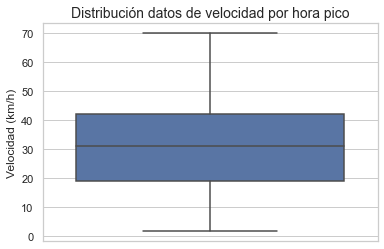

In [12]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico1car = velocidades[(velocidades.pico_valle == "pico1")]
boxplot = sns.boxplot(y=pico1car["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

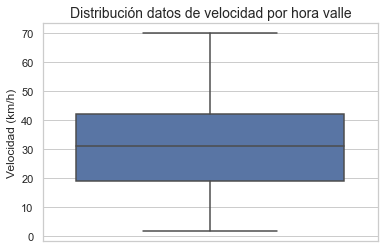

In [13]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico1car = pico1car[(pico1car.velocity_k <= 100)]
boxplot = sns.boxplot(y=pico1car["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [14]:
pico1car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Pico1.shp")

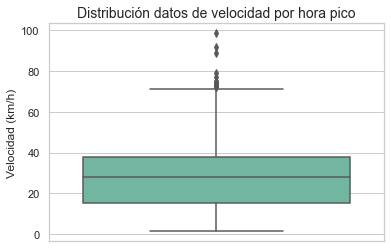

In [15]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico2car = velocidades[(velocidades.pico_valle == "pico2")]
boxplot = sns.boxplot(y=pico2car["velocity_k"], palette="Set2")
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

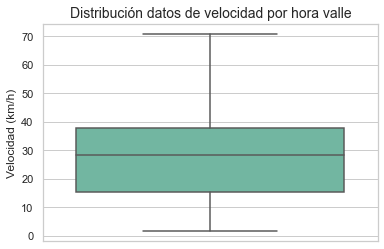

In [20]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico2car = pico2car[(pico2car.velocity_k <= 71)]
boxplot = sns.boxplot(y=pico2car["velocity_k"], palette="Set2")
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [21]:
pico2car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Pico2.shp")

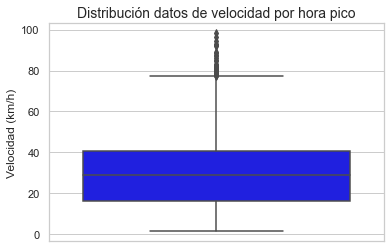

In [22]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico3car = velocidades[(velocidades.pico_valle == "pico3")]
boxplot = sns.boxplot(y=pico3car["velocity_k"], color='blue')
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

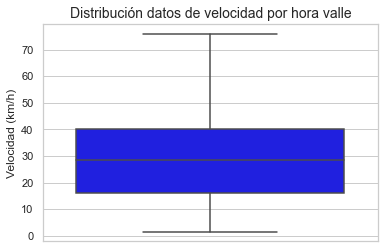

In [27]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico3car = pico3car[(pico3car.velocity_k <= 76)]
boxplot = sns.boxplot(y=pico3car["velocity_k"], color='blue')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [28]:
pico3car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Pico3.shp")

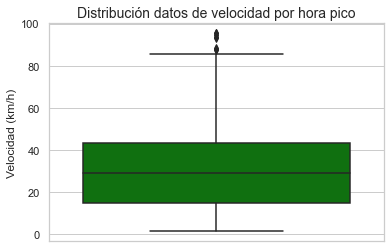

In [29]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico4car = velocidades[(velocidades.pico_valle == "pico4")]
boxplot = sns.boxplot(y=pico4car["velocity_k"], color='green')
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

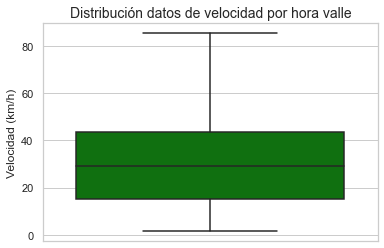

In [33]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico4car = pico4car[(pico4car.velocity_k <= 87)]
boxplot = sns.boxplot(y=pico4car["velocity_k"], color='green')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [34]:
pico4car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Pico4.shp")

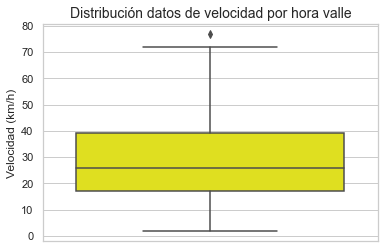

In [35]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle1car = velocidades[(velocidades.pico_valle == "valle1")]
boxplot = sns.boxplot(y=valle1car["velocity_k"], color='yellow')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

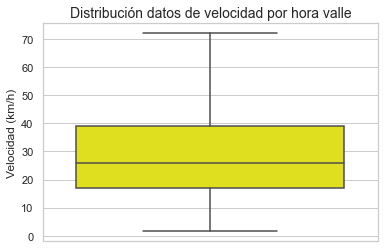

In [36]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle1car = valle1car[(valle1car.velocity_k <= 75)]
boxplot = sns.boxplot(y=valle1car["velocity_k"], color='yellow')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [37]:
valle1car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Valle1.shp")

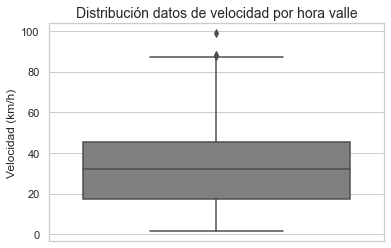

In [38]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle2car = velocidades[(velocidades.pico_valle == "valle2")]
boxplot = sns.boxplot(y=valle2car["velocity_k"], color='gray')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

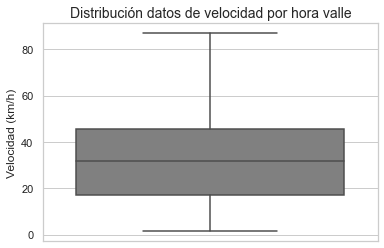

In [41]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle2car = valle2car[(valle2car.velocity_k <= 87)]
boxplot = sns.boxplot(y=valle2car["velocity_k"], color='gray')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [42]:
valle2car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Valle2.shp")

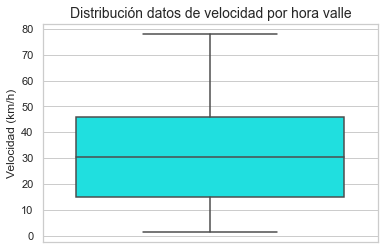

In [43]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle3car = velocidades[(velocidades.pico_valle == "valle3")]
boxplot = sns.boxplot(y=valle3car["velocity_k"], color='cyan')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

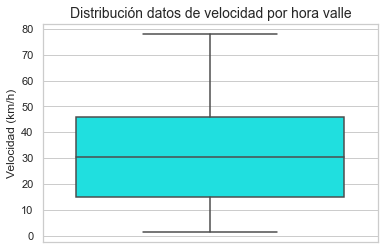

In [44]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle3car = valle3car[(valle3car.velocity_k <= 100)]
boxplot = sns.boxplot(y=valle3car["velocity_k"], color='cyan')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [45]:
valle3car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Valle3.shp")

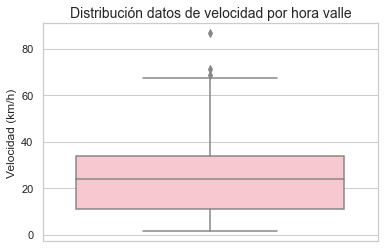

In [46]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle4car = velocidades[(velocidades.pico_valle == "valle4")]
boxplot = sns.boxplot(y=valle4car["velocity_k"], color='pink')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

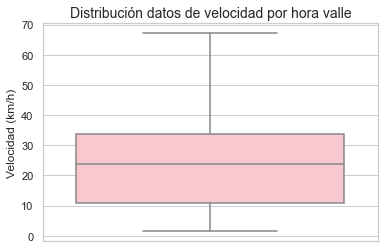

In [50]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle4car = valle4car[(valle4car.velocity_k <= 68)]
boxplot = sns.boxplot(y=valle4car["velocity_k"], color='pink')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [51]:
valle4car.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/comparacion/Carro/Valle4.shp")

Continua en el codigo Asignacion_por_horario.ipynb donde se distinguiran las velocidades segun el horario a la red vial

## Moto

In [22]:
#calcular los segundos a partir de la función definida
velocidadesm['sec'] = velocidadesm.apply(
    lambda row: time_to_num(
        time_str=row['tiempo']
    ),
    axis=1
)

In [23]:
#Se calculan los datos de minutos y segundos 
velocidadesm["min"] = (velocidadesm["sec"] /60)
velocidadesm["hr"] = (velocidadesm["min"] /60)

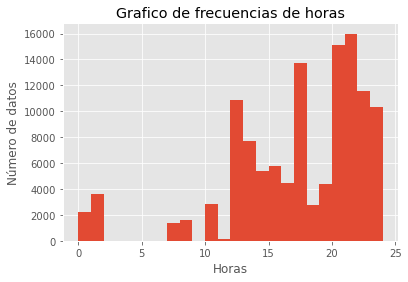

In [24]:
#Una vez obtenidos los datos se construye un histograma para visualizar el número de datos segun la hora definida
n_group = 24
#Definición del histograma
hist, bin_edges = np.histogram(velocidadesm["hr"], n_group)
plt.hist(velocidadesm["hr"], bins=bin_edges)
plt.xlabel("Horas")
plt.ylabel("Número de datos")
plt.title("Grafico de frecuencias de horas")
plt.show()

In [25]:
#Obtener rangos pico y valle segun los definidos para la ciudad
velocidadesm["pico_valle"] =0
for i in range(len(velocidadesm)):
    if (velocidadesm["hr"].iloc[i] >= 7.25) & (velocidadesm["hr"].iloc[i] <= 8.25):
        velocidadesm["pico_valle"].iloc[i] = "pico1"
    elif (velocidadesm["hr"].iloc[i] >= 8.25) & (velocidadesm["hr"].iloc[i] <= 11.75):
        velocidadesm["pico_valle"].iloc[i] = "valle1"
    elif (velocidadesm["hr"].iloc[i] >= 11.75) & (velocidadesm["hr"].iloc[i] <= 12.75):
        velocidadesm["pico_valle"].iloc[i] = "pico2"
    elif (velocidadesm["hr"].iloc[i] >= 12.75) & (velocidadesm["hr"].iloc[i] <= 13.75):
        velocidadesm["pico_valle"].iloc[i] = "valle2"
    elif (velocidadesm["hr"].iloc[i] >= 13.75) & (velocidadesm["hr"].iloc[i] <= 14.75):
        velocidadesm["pico_valle"].iloc[i] = "pico3"
    elif (velocidadesm["hr"].iloc[i] >= 14.75) & (velocidadesm["hr"].iloc[i] <= 17.75):
        velocidadesm["pico_valle"].iloc[i] = "valle3"
    elif (velocidadesm["hr"].iloc[i] >= 17.75) & (velocidadesm["hr"].iloc[i] <= 18.75):
        velocidadesm["pico_valle"].iloc[i] = "pico4"
    elif ((velocidadesm["hr"].iloc[i] >= 18.75) & (velocidadesm["hr"].iloc[i] <= 24)) | ((velocidadesm["hr"].iloc[i] >= 0) & (velocidadesm["hr"].iloc[i] <= 7.25)):
        velocidadesm["pico_valle"].iloc[i] = "valle4"

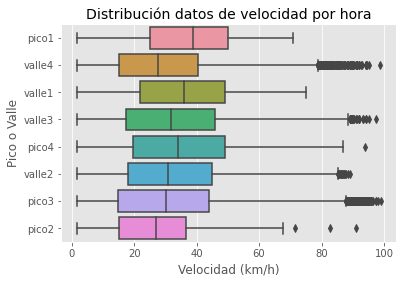

In [26]:
#Se realiza el boxplot de las velocidades en carro de la RED teniendo en cuenta la franja horaria de estas
boxplot = sns.boxplot(y=velocidadesm["pico_valle"], x=velocidadesm["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora", fontsize=14)
boxplot.set_xlabel("Velocidad (km/h)", fontsize=12)
boxplot.set_ylabel("Pico o Valle", fontsize=12)
plt.show()

In [27]:
#Se guarda el shape en la ubicación deseada
#velocidades.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/carro_pv1.shp")
velocidadesm.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/franjas/Moto.shp")

## Bici

In [28]:
#calcular los segundos a partir de la función definida
velocidadesb['sec'] = velocidadesb.apply(
    lambda row: time_to_num(
        time_str=row['tiempo']
    ),
    axis=1
)

In [29]:
#Se calculan los datos de minutos y segundos 
velocidadesb["min"] = (velocidadesb["sec"] /60)
velocidadesb["hr"] = (velocidadesb["min"] /60)

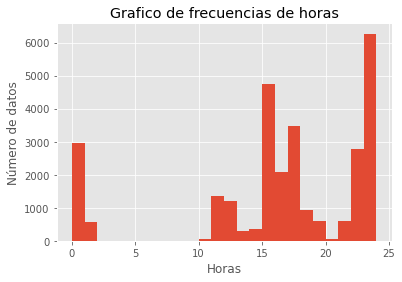

In [30]:
#Una vez obtenidos los datos se construye un histograma para visualizar el número de datos segun la hora definida
n_group = 24
#Definición del histograma
hist, bin_edges = np.histogram(velocidadesb["hr"], n_group)
plt.hist(velocidadesb["hr"], bins=bin_edges)
plt.xlabel("Horas")
plt.ylabel("Número de datos")
plt.title("Grafico de frecuencias de horas")
plt.show()

In [31]:
#Obtener rangos pico y valle segun los definidos para la ciudad
velocidadesb["pico_valle"] =0
for i in range(len(velocidadesb)):
    if (velocidadesb["hr"].iloc[i] >= 7.25) & (velocidadesb["hr"].iloc[i] <= 8.25):
        velocidadesb["pico_valle"].iloc[i] = "pico1"
    elif (velocidadesb["hr"].iloc[i] >= 8.25) & (velocidadesb["hr"].iloc[i] <= 11.75):
        velocidadesb["pico_valle"].iloc[i] = "valle1"
    elif (velocidadesb["hr"].iloc[i] >= 11.75) & (velocidadesb["hr"].iloc[i] <= 12.75):
        velocidadesb["pico_valle"].iloc[i] = "pico2"
    elif (velocidadesb["hr"].iloc[i] >= 12.75) & (velocidadesb["hr"].iloc[i] <= 13.75):
        velocidadesb["pico_valle"].iloc[i] = "valle2"
    elif (velocidadesb["hr"].iloc[i] >= 13.75) & (velocidadesb["hr"].iloc[i] <= 14.75):
        velocidadesb["pico_valle"].iloc[i] = "pico3"
    elif (velocidadesb["hr"].iloc[i] >= 14.75) & (velocidadesb["hr"].iloc[i] <= 17.75):
        velocidadesb["pico_valle"].iloc[i] = "valle3"
    elif (velocidadesb["hr"].iloc[i] >= 17.75) & (velocidadesb["hr"].iloc[i] <= 18.75):
        velocidadesb["pico_valle"].iloc[i] = "pico4"
    elif ((velocidadesb["hr"].iloc[i] >= 18.75) & (velocidadesb["hr"].iloc[i] <= 24)) | ((velocidadesb["hr"].iloc[i] >= 0) & (velocidadesb["hr"].iloc[i] <= 7.25)):
        velocidadesb["pico_valle"].iloc[i] = "valle4"

,ID,latitud,longitud,altura,fecha,tiempo,timestamp,file,t0,A0,velocity_m,velocity_k,slope,geometry,sec,min,hr,pico_valle
0,2,4.43873,-75.19158,1092.88000,01-01-1970,00:26:35,1970-01-01 00:26:35,1969-12-31_19-26_Wed.gpx,00:26:33,1090.18000,5.94567,21.40440,22.70562,POINT (876338.177 982680.433),1595,26.58333,0.44306,valle4
1,3,4.43871,-75.19157,1084.98000,01-01-1970,00:26:38,1970-01-01 00:26:38,1969-12-31_19-26_Wed.gpx,00:26:35,1092.88000,0.93898,3.38034,-280.44484,POINT (876344.719 982678.869),1598,26.63333,0.44389,valle4
2,4,4.43862,-75.19149,1080.38000,01-01-1970,00:26:41,1970-01-01 00:26:41,1969-12-31_19-26_Wed.gpx,00:26:38,1084.98000,4.40327,15.85178,-34.82259,POINT (876349.644 982672.602),1601,26.68333,0.44472,valle4
3,5,4.43857,-75.19140,1078.18000,01-01-1970,00:26:43,1970-01-01 00:26:43,1969-12-31_19-26_Wed.gpx,00:26:41,1080.38000,5.64505,20.32219,-19.48608,POINT (876358.874 982664.818),1603,26.71667,0.44528,valle4
4,6,4.43854,-75.19128,1075.68000,01-01-1970,00:26:46,1970-01-01 00:26:46,1969-12-31_19-26_Wed.gpx,00:26:43,1078.18000,4.44119,15.98829,-18.76373,POINT (876370.195 982660.228),1606,26.76667,0.44611,valle4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28292,30198,4.43132,-75.20246,1130.40000,13-01-2021,00:04:26,2021-01-13 00:04:26,Volviendo_.gpx,00:04:25,1130.30000,0.91225,3.28409,10.96193,POINT (875134.340 981862.828),266,4.43333,0.07389,valle4
28293,30199,4.43132,-75.20246,1130.40000,13-01-2021,00:04:27,2021-01-13 00:04:27,Volviendo_.gpx,00:04:26,1130.40000,0.34988,1.25958,0.00000,POINT (875134.506 981862.220),267,4.45000,0.07417,valle4
28294,30200,4.43131,-75.20247,1130.40000,13-01-2021,00:04:28,2021-01-13 00:04:28,Volviendo_.gpx,00:04:27,1130.40000,0.95376,3.43355,0.00000,POINT (875134.172 981861.778),268,4.46667,0.07444,valle4
28295,30201,4.43131,-75.20248,1130.40000,13-01-2021,00:04:29,2021-01-13 00:04:29,Volviendo_.gpx,00:04:28,1130.40000,1.19501,4.30205,0.00000,POINT (875133.228 981861.282),269,4.48333,0.07472,valle4


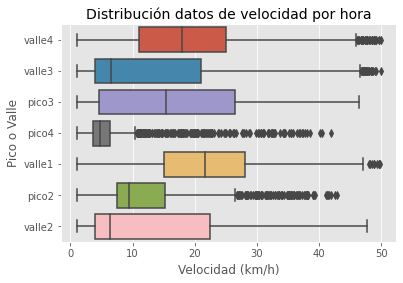

In [32]:
#Se realiza el boxplot de las velocidades en carro de la RED teniendo en cuenta la franja horaria de estas
boxplot = sns.boxplot(y=velocidadesb["pico_valle"], x=velocidadesb["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora", fontsize=14)
boxplot.set_xlabel("Velocidad (km/h)", fontsize=12)
boxplot.set_ylabel("Pico o Valle", fontsize=12)
plt.show()

In [33]:
#Se guarda el shape en la ubicación deseada
#velocidades.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/carro_pv1.shp")
velocidadesb.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/franjas/Bici.shp")

## TPC

In [34]:
#calcular los segundos a partir de la función definida
velocidadest['sec'] = velocidadest.apply(
    lambda row: time_to_num(
        time_str=row['tiempo']
    ),
    axis=1
)

In [35]:
#Se calculan los datos de minutos y segundos 
velocidadest["min"] = (velocidadest["sec"] /60)
velocidadest["hr"] = (velocidadest["min"] /60)

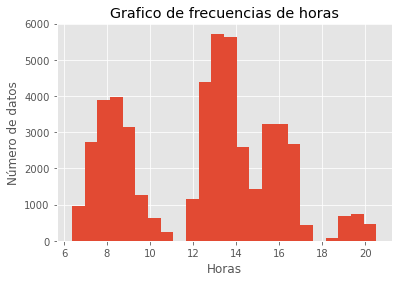

In [36]:
#Una vez obtenidos los datos se construye un histograma para visualizar el número de datos segun la hora definida
n_group = 24
#Definición del histograma
hist, bin_edges = np.histogram(velocidadest["hr"], n_group)
plt.hist(velocidadest["hr"], bins=bin_edges)
plt.xlabel("Horas")
plt.ylabel("Número de datos")
plt.title("Grafico de frecuencias de horas")
plt.show()

In [37]:
#Obtener rangos pico y valle segun los definidos para la ciudad
velocidadest["pico_valle"] =0
for i in range(len(velocidadest)):
    if (velocidadest["hr"].iloc[i] >= 7.25) & (velocidadest["hr"].iloc[i] <= 8.25):
        velocidadest["pico_valle"].iloc[i] = "pico1"
    elif (velocidadest["hr"].iloc[i] >= 8.25) & (velocidadest["hr"].iloc[i] <= 11.75):
        velocidadest["pico_valle"].iloc[i] = "valle1"
    elif (velocidadest["hr"].iloc[i] >= 11.75) & (velocidadest["hr"].iloc[i] <= 12.75):
        velocidadest["pico_valle"].iloc[i] = "pico2"
    elif (velocidadest["hr"].iloc[i] >= 12.75) & (velocidadest["hr"].iloc[i] <= 13.75):
        velocidadest["pico_valle"].iloc[i] = "valle2"
    elif (velocidadest["hr"].iloc[i] >= 13.75) & (velocidadest["hr"].iloc[i] <= 14.75):
        velocidadest["pico_valle"].iloc[i] = "pico3"
    elif (velocidadest["hr"].iloc[i] >= 14.75) & (velocidadest["hr"].iloc[i] <= 17.75):
        velocidadest["pico_valle"].iloc[i] = "valle3"
    elif (velocidadest["hr"].iloc[i] >= 17.75) & (velocidadest["hr"].iloc[i] <= 18.75):
        velocidadest["pico_valle"].iloc[i] = "pico4"
    elif ((velocidadest["hr"].iloc[i] >= 18.75) & (velocidadest["hr"].iloc[i] <= 24)) | ((velocidadest["hr"].iloc[i] >= 0) & (velocidadest["hr"].iloc[i] <= 7.25)):
        velocidadest["pico_valle"].iloc[i] = "valle4"

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,angulo_vel,geometry,sec,min,hr,pico_valle
0,1,1,1324.00000,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,307.39506,POINT (870423.510 984235.894),33115,551.91667,9.19861,valle1
1,1,2,1325.00000,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,201.45898,POINT (870392.095 984259.908),33122,552.03333,9.20056,valle1
2,1,3,1331.00000,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,192.94028,POINT (870349.370 984151.215),33145,552.41667,9.20694,valle1
3,1,4,1333.00000,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,126.86010,POINT (870340.055 984110.675),33153,552.55000,9.20917,valle1
4,1,5,1333.00000,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,119.16920,POINT (870354.838 984099.591),33157,552.61667,9.21028,valle1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49279,_ 2015-08-14_08-59_vie - Julieth.gpx,46025,1040.00000,1.59447,5.74010,2015-08-14 14:19:30,4.44378,-75.17069,14:19:30,74.59437,POINT (878660.911 983233.991),51570,859.50000,14.32500,pico3
49280,_ 2015-08-14_08-59_vie - Julieth.gpx,46026,1040.00000,2.61968,9.43086,2015-08-14 14:19:32,4.44379,-75.17065,14:19:32,75.00027,POINT (878665.742 983235.322),51572,859.53333,14.32556,pico3
49281,_ 2015-08-14_08-59_vie - Julieth.gpx,46027,1039.00000,2.82994,10.18779,2015-08-14 14:19:35,4.44381,-75.17057,14:19:35,76.43489,POINT (878672.372 983237.098),51575,859.58333,14.32639,pico3
49282,_ 2015-08-14_08-59_vie - Julieth.gpx,46028,1038.00000,1.68487,6.06554,2015-08-14 14:19:37,4.44382,-75.17054,14:19:37,74.85601,POINT (878678.135 983238.489),51577,859.61667,14.32694,pico3


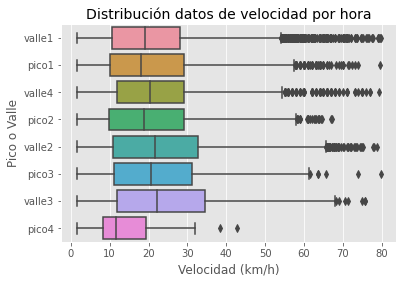

In [38]:
#Se realiza el boxplot de las velocidades en carro de la RED teniendo en cuenta la franja horaria de estas
boxplot = sns.boxplot(y=velocidadest["pico_valle"], x=velocidadest["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora", fontsize=14)
boxplot.set_xlabel("Velocidad (km/h)", fontsize=12)
boxplot.set_ylabel("Pico o Valle", fontsize=12)
plt.show()

In [39]:
#Se guarda el shape en la ubicación deseada
#velocidades.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/carro_pv1.shp")
velocidadest.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/franjas/TPC.shp")

In [40]:
#Una vez visto los datos se hace un rango mas cerrado sacando los datos por hora

#Se sacan los valores con estas caracteristicas

car1 = velocidades[(velocidades.hr >= 6) & (velocidades.hr <= 7)]
car2 = velocidades[(velocidades.hr >= 7) & (velocidades.hr <= 8)]
car3 = velocidades[(velocidades.hr >= 8) & (velocidades.hr <= 9)]
car4 = velocidades[(velocidades.hr >= 9) & (velocidades.hr <= 10)]
car5 = velocidades[(velocidades.hr >= 10) & (velocidades.hr <= 11)]
car6 = velocidades[(velocidades.hr >= 11) & (velocidades.hr <= 12)]
car7 = velocidades[(velocidades.hr >= 12) & (velocidades.hr <= 13)]
car8 = velocidades[(velocidades.hr >= 13) & (velocidades.hr <= 14)]
car9 = velocidades[(velocidades.hr >= 14) & (velocidades.hr <= 15)]
car10 = velocidades[(velocidades.hr >= 15) & (velocidades.hr <= 16)]
car11 = velocidades[(velocidades.hr >= 16) & (velocidades.hr <= 17)]
car12 = velocidades[(velocidades.hr >= 17) & (velocidades.hr <= 18)]
car13 = velocidades[(velocidades.hr >= 18) & (velocidades.hr <= 19)]
car14 = velocidades[(velocidades.hr >= 19) & (velocidades.hr <= 20)]
car15 = velocidades[(velocidades.hr >= 20) & (velocidades.hr <= 21)]
car16 = velocidades[(velocidades.hr >= 21) & (velocidades.hr <= 22)]
car17 = velocidades[(velocidades.hr >= 22) & (velocidades.hr <= 23)]

#Secalculan los datos segun su jerarquia para la red 1
#La media aritmética se define como la suma de N elementos dividida entre N.
media1 = car1["velocity_k"].mean()
media2 = car2["velocity_k"].mean()
media3 = car3["velocity_k"].mean()
media4 = car4["velocity_k"].mean()
media5 = car5["velocity_k"].mean()
media6 = car6["velocity_k"].mean()
media7 = car7["velocity_k"].mean()
media8 = car8["velocity_k"].mean()
media9 = car9["velocity_k"].mean()
media10 = car10["velocity_k"].mean()
media11 = car11["velocity_k"].mean()
media12 = car12["velocity_k"].mean()
media13 = car13["velocity_k"].mean()
media14 = car14["velocity_k"].mean()
media15 = car15["velocity_k"].mean()
media16 = car16["velocity_k"].mean()
media17 = car17["velocity_k"].mean()
#La mediana es el valor que dentro del conjunto de datos es menor que el 50% de los datos y mayor que el 50% restante.
mediana1 = car1["velocity_k"].median()
mediana2 = car2["velocity_k"].median()
mediana3 = car3["velocity_k"].median()
mediana4 = car4["velocity_k"].median()
mediana5 = car5["velocity_k"].median()
mediana6 = car6["velocity_k"].median()
mediana7 = car7["velocity_k"].median()
mediana8 = car8["velocity_k"].median()
mediana9 = car9["velocity_k"].median()
mediana10 = car10["velocity_k"].median()
mediana11 = car11["velocity_k"].median()
mediana12 = car12["velocity_k"].median()
mediana13 = car13["velocity_k"].median()
mediana14 = car14["velocity_k"].median()
mediana15 = car15["velocity_k"].median()
mediana16 = car16["velocity_k"].median()
mediana17 = car17["velocity_k"].median()

#La desviación típica mide la dispersión de los datos respecto a la media
desvstd1 = car1["velocity_k"].std(ddof=0)
desvstd2 = car2["velocity_k"].std(ddof=0)
desvstd3 = car3["velocity_k"].std(ddof=0)
desvstd4 = car4["velocity_k"].std(ddof=0)
desvstd5 = car5["velocity_k"].std(ddof=0)
desvstd6 = car6["velocity_k"].std(ddof=0)
desvstd7 = car7["velocity_k"].std(ddof=0)
desvstd8 = car8["velocity_k"].std(ddof=0)
desvstd9 = car9["velocity_k"].std(ddof=0)
desvstd10 = car10["velocity_k"].std(ddof=0)
desvstd11 = car11["velocity_k"].std(ddof=0)
desvstd12 = car12["velocity_k"].std(ddof=0)
desvstd13 = car13["velocity_k"].std(ddof=0)
desvstd14 = car14["velocity_k"].std(ddof=0)
desvstd15 = car15["velocity_k"].std(ddof=0)
desvstd16 = car16["velocity_k"].std(ddof=0)
desvstd17 = car17["velocity_k"].std(ddof=0)

var1 = car1["velocity_k"].var(ddof=0)
var2 = car2["velocity_k"].var(ddof=0)
var3 = car3["velocity_k"].var(ddof=0)
var4 = car4["velocity_k"].var(ddof=0)
var5 = car5["velocity_k"].var(ddof=0)
var6 = car6["velocity_k"].var(ddof=0)
var7 = car7["velocity_k"].var(ddof=0)
var8 = car8["velocity_k"].var(ddof=0)
var9 = car9["velocity_k"].var(ddof=0)
var10 = car10["velocity_k"].var(ddof=0)
var11 = car11["velocity_k"].var(ddof=0)
var12 = car12["velocity_k"].var(ddof=0)
var13 = car13["velocity_k"].var(ddof=0)
var14 = car14["velocity_k"].var(ddof=0)
var15 = car15["velocity_k"].var(ddof=0)
var16 = car16["velocity_k"].var(ddof=0)
var17 = car17["velocity_k"].var(ddof=0)

#Se imprimen para visualizar
print("Car1 6-7")
print("Media: ", media1)
print("Mediana: ", mediana1)
print("Desviasión estandar: ", desvstd1)
print("Variancia: ", var1)
print(" ------------------------------------- ")
print("Car2 7-8")
print("Media: ", media2)
print("Mediana: ", mediana2)
print("Desviasión estandar: ", desvstd2)
print("Variancia: ", var2)
print(" ------------------------------------- ")
print("Car3 8-9")
print("Media: ", media3)
print("Mediana: ", mediana3)
print("Desviasión estandar: ", desvstd3)
print("Variancia: ", var3)
print(" ------------------------------------- ")
print("Car4 9-10")
print("Media: ", media4)
print("Mediana: ", mediana4)
print("Desviasión estandar: ", desvstd4)
print("Variancia: ", var4)
print(" ------------------------------------- ")
print("Car5 10-11")
print("Media: ", media5)
print("Mediana: ", mediana5)
print("Desviasión estandar: ", desvstd5)
print("Variancia: ", var5)
print(" ------------------------------------- ")
print("Car6 11-12")
print("Media: ", media6)
print("Mediana: ", mediana6)
print("Desviasión estandar: ", desvstd6)
print("Variancia: ", var6)
print(" ------------------------------------- ")
print("Car7 12-13")
print("Media: ", media7)
print("Mediana: ", mediana7)
print("Desviasión estandar: ", desvstd7)
print("Variancia: ", var7)
print(" ------------------------------------- ")
print("Car8 13-14")
print("Media: ", media8)
print("Mediana: ", mediana8)
print("Desviasión estandar: ", desvstd8)
print("Variancia: ", var8)
print(" ------------------------------------- ")
print("Car9 14-15")
print("Media: ", media9)
print("Mediana: ", mediana9)
print("Desviasión estandar: ", desvstd9)
print("Variancia: ", var9)
print(" ------------------------------------- ")
print("Car10 15-16")
print("Media: ", media10)
print("Mediana: ", mediana10)
print("Desviasión estandar: ", desvstd10)
print("Variancia: ", var10)
print(" ------------------------------------- ")
print("Car11 16-17")
print("Media: ", media11)
print("Mediana: ", mediana11)
print("Desviasión estandar: ", desvstd11)
print("Variancia: ", var11)
print(" ------------------------------------- ")
print("Car12 17-18")
print("Media: ", media12)
print("Mediana: ", mediana12)
print("Desviasión estandar: ", desvstd12)
print("Variancia: ", var12)
print(" ------------------------------------- ")
print("Car13 18-19")
print("Media: ", media13)
print("Mediana: ", mediana13)
print("Desviasión estandar: ", desvstd13)
print("Variancia: ", var13)
print(" ------------------------------------- ")
print("Car14 19-20")
print("Media: ", media14)
print("Mediana: ", mediana14)
print("Desviasión estandar: ", desvstd14)
print("Variancia: ", var14)
print(" ------------------------------------- ")
print("Car15 20-21")
print("Media: ", media15)
print("Mediana: ", mediana15)
print("Desviasión estandar: ", desvstd15)
print("Variancia: ", var15)
print(" ------------------------------------- ")
print("Car16 21-22")
print("Media: ", media16)
print("Mediana: ", mediana16)
print("Desviasión estandar: ", desvstd16)
print("Variancia: ", var16)
print(" ------------------------------------- ")
print("Car17 22-23")
print("Media: ", media17)
print("Mediana: ", mediana17)
print("Desviasión estandar: ", desvstd17)
print("Variancia: ", var17)

Car1 6-7
Media:  35.60250231696015
Mediana:  37.0
Desviasión estandar:  14.369056034069738
Variancia:  206.46977131023596
 ------------------------------------- 
Car2 7-8
Media:  31.102471576866034
Mediana:  31.0
Desviasión estandar:  15.258579390084687
Variancia:  232.8242450035172
 ------------------------------------- 
Car3 8-9
Media:  28.6488940628638
Mediana:  30.0
Desviasión estandar:  13.533256861087501
Variancia:  183.14904126817194
 ------------------------------------- 
Car4 9-10
Media:  24.169123505976103
Mediana:  24.0
Desviasión estandar:  13.628745065501935
Variancia:  185.74269206044335
 ------------------------------------- 
Car5 10-11
Media:  29.837895662368098
Mediana:  29.0
Desviasión estandar:  16.205803547127985
Variancia:  262.628068608106
 ------------------------------------- 
Car6 11-12
Media:  27.913366336633665
Mediana:  26.0
Desviasión estandar:  14.993818953808693
Variancia:  224.8146068195928
 ------------------------------------- 
Car7 12-13
Media:  27.90

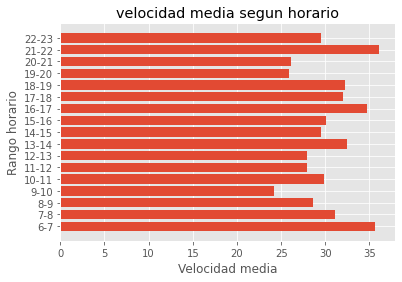

In [41]:
## Declaramos valores para el eje x
eje_x = ['6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', 
         '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23']
 
## Declaramos valores para el eje y
eje_y = [media1, media2, media3, media4, media5, media6, media7, media8, media9, media10, media11, media12,
        media13, media14, media15, media16, media17]
 
## Creamos Gráfica
plt.barh(eje_x, eje_y)
 
## Legenda en el eje y
plt.ylabel('Rango horario')
 
## Legenda en el eje x
plt.xlabel('Velocidad media')
 
## Título de Gráfica
plt.title('velocidad media segun horario')
 
## Mostramos Gráfica
plt.show()

In [30]:
#Una vez visto los datos se hace un rango mas cerrado sacando los datos por hora

#Se sacan los valores con estas caracteristicas
car1 = velocidades[(velocidades.hr >= 10) & (velocidades.hr <= 13)]
car2 = velocidades[(velocidades.hr >= 13) & (velocidades.hr <= 14)]
car3 = velocidades[(velocidades.hr >= 14) & (velocidades.hr <= 17)]
car4 = velocidades[(velocidades.hr >= 17) & (velocidades.hr <= 19)]
car5 = velocidades[(velocidades.hr >= 19) & (velocidades.hr <= 21)]
car6 = velocidades[(velocidades.hr >= 21) & (velocidades.hr <= 24)]
#car7 = velocidades[(velocidades.hr >= 18) & (velocidades.hr <= 19)]
#car8 = velocidades[(velocidades.hr >= 19) & (velocidades.hr <= 20)]
#car9 = velocidades[(velocidades.hr >= 20) & (velocidades.hr <= 21)]
#car10 = velocidades[(velocidades.hr >= 21) & (velocidades.hr <= 22)]
#car11 = velocidades[(velocidades.hr >= 22) & (velocidades.hr <= 23)]
#car12 = velocidades[(velocidades.hr >= 23) & (velocidades.hr <= 24)]

#Secalculan los datos segun su jerarquia para la red 1
#La media aritmética se define como la suma de N elementos dividida entre N.
media1 = car1["velocity_k"].mean()
media2 = car2["velocity_k"].mean()
media3 = car3["velocity_k"].mean()
media4 = car4["velocity_k"].mean()
media5 = car5["velocity_k"].mean()
media6 = car6["velocity_k"].mean()
#media7 = car7["velocity_k"].mean()
#media8 = car8["velocity_k"].mean()
#media9 = car9["velocity_k"].mean()
#media10 = car10["velocity_k"].mean()
#media11 = car11["velocity_k"].mean()
#media12 = car12["velocity_k"].mean()
#La mediana es el valor que dentro del conjunto de datos es menor que el 50% de los datos y mayor que el 50% restante.
mediana1 = car1["velocity_k"].median()
mediana2 = car2["velocity_k"].median()
mediana3 = car3["velocity_k"].median()
mediana4 = car4["velocity_k"].median()
mediana5 = car5["velocity_k"].median()
mediana6 = car6["velocity_k"].median()
#mediana7 = car7["velocity_k"].median()
#mediana8 = car8["velocity_k"].median()
#mediana9 = car9["velocity_k"].median()
#mediana10 = car10["velocity_k"].median()
#mediana11 = car11["velocity_k"].median()
#mediana12 = car12["velocity_k"].median()

#La desviación típica mide la dispersión de los datos respecto a la media
desvstd1 = car1["velocity_k"].std(ddof=0)
desvstd2 = car2["velocity_k"].std(ddof=0)
desvstd3 = car3["velocity_k"].std(ddof=0)
desvstd4 = car4["velocity_k"].std(ddof=0)
desvstd5 = car5["velocity_k"].std(ddof=0)
desvstd6 = car6["velocity_k"].std(ddof=0)
#desvstd7 = car7["velocity_k"].std(ddof=0)
#desvstd8 = car8["velocity_k"].std(ddof=0)
#desvstd9 = car9["velocity_k"].std(ddof=0)
#desvstd10 = car10["velocity_k"].std(ddof=0)
#desvstd11 = car11["velocity_k"].std(ddof=0)
#desvstd12 = car12["velocity_k"].std(ddof=0)

var1 = car1["velocity_k"].var(ddof=0)
var2 = car2["velocity_k"].var(ddof=0)
var3 = car3["velocity_k"].var(ddof=0)
var4 = car4["velocity_k"].var(ddof=0)
var5 = car5["velocity_k"].var(ddof=0)
var6 = car6["velocity_k"].var(ddof=0)
#var7 = car7["velocity_k"].var(ddof=0)
#var8 = car8["velocity_k"].var(ddof=0)
#var9 = car9["velocity_k"].var(ddof=0)
#var10 = car10["velocity_k"].var(ddof=0)
#var11 = car11["velocity_k"].var(ddof=0)
#var12 = car12["velocity_k"].var(ddof=0)

#Se imprimen para visualizar
print("Car1 12-13")
print("Media: ", media1)
print("Mediana: ", mediana1)
print("Desviasión estandar: ", desvstd1)
print("Variancia: ", var1)
print(" ------------------------------------- ")
print("Car2 13-14")
print("Media: ", media2)
print("Mediana: ", mediana2)
print("Desviasión estandar: ", desvstd2)
print("Variancia: ", var2)
print(" ------------------------------------- ")
print("Car3 14-17")
print("Media: ", media3)
print("Mediana: ", mediana3)
print("Desviasión estandar: ", desvstd3)
print("Variancia: ", var3)
print(" ------------------------------------- ")
print("Car4 17-19")
print("Media: ", media4)
print("Mediana: ", mediana4)
print("Desviasión estandar: ", desvstd4)
print("Variancia: ", var4)
print(" ------------------------------------- ")
print("Car5 19-21")
print("Media: ", media5)
print("Mediana: ", mediana5)
print("Desviasión estandar: ", desvstd5)
print("Variancia: ", var5)
print(" ------------------------------------- ")
print("Car6 21-24")
print("Media: ", media6)
print("Mediana: ", mediana6)
print("Desviasión estandar: ", desvstd6)
print("Variancia: ", var6)
#print(" ------------------------------------- ")
#print("Car7 18-19")
#print("Media: ", media7)
#print("Mediana: ", mediana7)
#print("Desviasión estandar: ", desvstd7)
#print("Variancia: ", var7)
#print(" ------------------------------------- ")
#print("Car8 19-20")
#print("Media: ", media8)
#print("Mediana: ", mediana8)
#print("Desviasión estandar: ", desvstd8)
#print("Variancia: ", var8)
#print(" ------------------------------------- ")
#print("Car9 20-21")
#print("Media: ", media9)
#print("Mediana: ", mediana9)
#print("Desviasión estandar: ", desvstd9)
#print("Variancia: ", var9)
#print(" ------------------------------------- ")
#print("Car10 21-22")
#print("Media: ", media10)
#print("Mediana: ", mediana10)
#print("Desviasión estandar: ", desvstd10)
#print("Variancia: ", var10)
#print(" ------------------------------------- ")
#print("Car11 22-23")
#print("Media: ", media11)
#print("Mediana: ", mediana11)
#print("Desviasión estandar: ", desvstd11)
#print("Variancia: ", var11)
#print(" ------------------------------------- ")
#print("Car12 23-24")
#print("Media: ", media12)
#print("Mediana: ", mediana12)
#print("Desviasión estandar: ", desvstd12)
#print("Variancia: ", var12)

Car1 12-13
Media:  26.664042567365712
Mediana:  27.67230695886918
Desviasión estandar:  16.01385119602951
Variancia:  256.44343012857576
 ------------------------------------- 
Car2 13-14
Media:  32.39936498708257
Mediana:  31.440179254746944
Desviasión estandar:  18.546434905635657
Variancia:  343.9702477089807
 ------------------------------------- 
Car3 14-17
Media:  31.728442755118596
Mediana:  30.9457278380484
Desviasión estandar:  19.644982723679213
Variancia:  385.9253462136548
 ------------------------------------- 
Car4 17-19
Media:  32.24938076946863
Mediana:  30.14303184080203
Desviasión estandar:  20.4541220687228
Variancia:  418.3711096022131
 ------------------------------------- 
Car5 19-21
Media:  25.66665652576897
Mediana:  25.02084395333827
Desviasión estandar:  16.80049485657055
Variancia:  282.25662742565345
 ------------------------------------- 
Car6 21-24
Media:  30.94083030890449
Mediana:  28.491563654987765
Desviasión estandar:  19.852848579875975
Variancia:  3

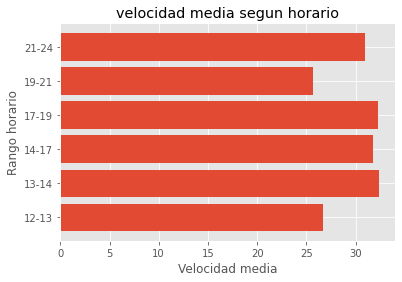

In [31]:
## Declaramos valores para el eje x
eje_x = ['12-13', '13-14', '14-17', '17-19', '19-21', '21-24']
 
## Declaramos valores para el eje y
eje_y = [media1, media2, media3, media4, media5, media6]
 
## Creamos Gráfica
plt.barh(eje_x, eje_y)
 
## Legenda en el eje y
plt.ylabel('Rango horario')
 
## Legenda en el eje x
plt.xlabel('Velocidad media')
 
## Título de Gráfica
plt.title('velocidad media segun horario')
 
## Mostramos Gráfica
plt.show()

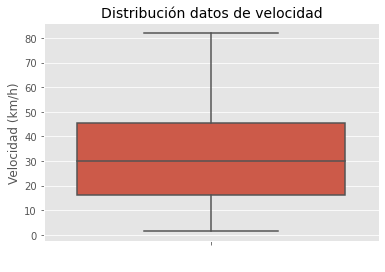

In [32]:
#Se realiza el boxplot de las velocidades en carro RED2
boxplot = sns.boxplot(y=car4["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad", fontsize=14)
boxplot.set_xlabel(" ", fontsize=12)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [58]:
#Una vez visto los datos se hace un rango mas cerrado sacando los datos por hora

#Se sacan los valores con estas caracteristicas
car1 = velocidades[(velocidades.hr >= 7.25) & (velocidades.hr <= 8.25)]
car2 = velocidades[(velocidades.hr >= 8.25) & (velocidades.hr <= 11.75)]
car3 = velocidades[(velocidades.hr >= 11.75) & (velocidades.hr <= 12.75)]
car4 = velocidades[(velocidades.hr >= 12.75) & (velocidades.hr <= 13.75)]
car5 = velocidades[(velocidades.hr >= 13.75) & (velocidades.hr <= 14.75)]
car6 = velocidades[(velocidades.hr >= 14.75) & (velocidades.hr <= 17.75)]
car7 = velocidades[(velocidades.hr >= 17.75) & (velocidades.hr <= 18.75)]
car8 = velocidades[((velocidades.hr >= 18.75) & (velocidades.hr <= 24)) | ((velocidades.hr >= 0) & (velocidades.hr <= 7.25))]
#car9 = velocidades[(velocidades.hr >= 20) & (velocidades.hr <= 21)]
#car10 = velocidades[(velocidades.hr >= 21) & (velocidades.hr <= 22)]
#car11 = velocidades[(velocidades.hr >= 22) & (velocidades.hr <= 23)]
#car12 = velocidades[(velocidades.hr >= 23) & (velocidades.hr <= 24)]

#Secalculan los datos segun su jerarquia para la red 1
#La media aritmética se define como la suma de N elementos dividida entre N.
media1 = car1["velocity_k"].mean()
media2 = car2["velocity_k"].mean()
media3 = car3["velocity_k"].mean()
media4 = car4["velocity_k"].mean()
media5 = car5["velocity_k"].mean()
media6 = car6["velocity_k"].mean()
media7 = car7["velocity_k"].mean()
media8 = car8["velocity_k"].mean()
#media9 = car9["velocity_k"].mean()
#media10 = car10["velocity_k"].mean()
#media11 = car11["velocity_k"].mean()
#media12 = car12["velocity_k"].mean()
#La mediana es el valor que dentro del conjunto de datos es menor que el 50% de los datos y mayor que el 50% restante.
mediana1 = car1["velocity_k"].median()
mediana2 = car2["velocity_k"].median()
mediana3 = car3["velocity_k"].median()
mediana4 = car4["velocity_k"].median()
mediana5 = car5["velocity_k"].median()
mediana6 = car6["velocity_k"].median()
mediana7 = car7["velocity_k"].median()
mediana8 = car8["velocity_k"].median()
#mediana9 = car9["velocity_k"].median()
#mediana10 = car10["velocity_k"].median()
#mediana11 = car11["velocity_k"].median()
#mediana12 = car12["velocity_k"].median()

#La desviación típica mide la dispersión de los datos respecto a la media
desvstd1 = car1["velocity_k"].std(ddof=0)
desvstd2 = car2["velocity_k"].std(ddof=0)
desvstd3 = car3["velocity_k"].std(ddof=0)
desvstd4 = car4["velocity_k"].std(ddof=0)
desvstd5 = car5["velocity_k"].std(ddof=0)
desvstd6 = car6["velocity_k"].std(ddof=0)
desvstd7 = car7["velocity_k"].std(ddof=0)
desvstd8 = car8["velocity_k"].std(ddof=0)
#desvstd9 = car9["velocity_k"].std(ddof=0)
#desvstd10 = car10["velocity_k"].std(ddof=0)
#desvstd11 = car11["velocity_k"].std(ddof=0)
#desvstd12 = car12["velocity_k"].std(ddof=0)

var1 = car1["velocity_k"].var(ddof=0)
var2 = car2["velocity_k"].var(ddof=0)
var3 = car3["velocity_k"].var(ddof=0)
var4 = car4["velocity_k"].var(ddof=0)
var5 = car5["velocity_k"].var(ddof=0)
var6 = car6["velocity_k"].var(ddof=0)
var7 = car7["velocity_k"].var(ddof=0)
var8 = car8["velocity_k"].var(ddof=0)
#var9 = car9["velocity_k"].var(ddof=0)
#var10 = car10["velocity_k"].var(ddof=0)
#var11 = car11["velocity_k"].var(ddof=0)
#var12 = car12["velocity_k"].var(ddof=0)

#Se imprimen para visualizar
print("Car1 07:15-08:15")
print("Media: ", media1)
print("Mediana: ", mediana1)
print("Desviasión estandar: ", desvstd1)
print("Variancia: ", var1)
print(" ------------------------------------- ")
print("Car2 08:15-11:45")
print("Media: ", media2)
print("Mediana: ", mediana2)
print("Desviasión estandar: ", desvstd2)
print("Variancia: ", var2)
print(" ------------------------------------- ")
print("Car3 11:45-12:45")
print("Media: ", media3)
print("Mediana: ", mediana3)
print("Desviasión estandar: ", desvstd3)
print("Variancia: ", var3)
print(" ------------------------------------- ")
print("Car4 12:45-13:45")
print("Media: ", media4)
print("Mediana: ", mediana4)
print("Desviasión estandar: ", desvstd4)
print("Variancia: ", var4)
print(" ------------------------------------- ")
print("Car5 13:45-14:45")
print("Media: ", media5)
print("Mediana: ", mediana5)
print("Desviasión estandar: ", desvstd5)
print("Variancia: ", var5)
print(" ------------------------------------- ")
print("Car6 14:45-17:45")
print("Media: ", media6)
print("Mediana: ", mediana6)
print("Desviasión estandar: ", desvstd6)
print("Variancia: ", var6)
print(" ------------------------------------- ")
print("Car7 17:45-18:45")
print("Media: ", media7)
print("Mediana: ", mediana7)
print("Desviasión estandar: ", desvstd7)
print("Variancia: ", var7)
print(" ------------------------------------- ")
print("Car8 18:45-07:15")
print("Media: ", media8)
print("Mediana: ", mediana8)
print("Desviasión estandar: ", desvstd8)
print("Variancia: ", var8)
#print(" ------------------------------------- ")
#print("Car9 20-21")
#print("Media: ", media9)
#print("Mediana: ", mediana9)
#print("Desviasión estandar: ", desvstd9)
#print("Variancia: ", var9)
#print(" ------------------------------------- ")
#print("Car10 21-22")
#print("Media: ", media10)
#print("Mediana: ", mediana10)
#print("Desviasión estandar: ", desvstd10)
#print("Variancia: ", var10)
#print(" ------------------------------------- ")
#print("Car11 22-23")
#print("Media: ", media11)
#print("Mediana: ", mediana11)
#print("Desviasión estandar: ", desvstd11)
#print("Variancia: ", var11)
#print(" ------------------------------------- ")
#print("Car12 23-24")
#print("Media: ", media12)
#print("Mediana: ", mediana12)
#print("Desviasión estandar: ", desvstd12)
#print("Variancia: ", var12)

Car1 07:15-08:15
Media:  30.58370607028754
Mediana:  31.0
Desviasión estandar:  15.590789038705399
Variancia:  243.07270284941643
 ------------------------------------- 
Car2 08:15-11:45
Media:  28.33937815126051
Mediana:  27.0
Desviasión estandar:  15.500217746907309
Variancia:  240.25675020154029
 ------------------------------------- 
Car3 11:45-12:45
Media:  27.098474834431062
Mediana:  28.245788427584046
Desviasión estandar:  14.981131606107803
Variancia:  224.43430419952216
 ------------------------------------- 
Car4 12:45-13:45
Media:  32.511585133050474
Mediana:  31.864066431227545
Desviasión estandar:  19.643367498221007
Variancia:  385.8618866701654
 ------------------------------------- 
Car5 13:45-14:45
Media:  30.21351434365961
Mediana:  29.3467495415538
Desviasión estandar:  17.70563095483855
Variancia:  313.48936750893705
 ------------------------------------- 
Car6 14:45-17:45
Media:  32.69594224585523
Mediana:  31.34290407655078
Desviasión estandar:  19.98308556275042

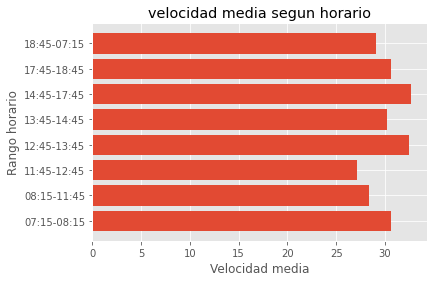

In [59]:
## Declaramos valores para el eje x
eje_x = ['07:15-08:15', '08:15-11:45', '11:45-12:45', '12:45-13:45', '13:45-14:45', '14:45-17:45', '17:45-18:45', '18:45-07:15']
 
## Declaramos valores para el eje y
eje_y = [media1, media2, media3, media4, media5, media6, media7, media8]
 
## Creamos Gráfica
plt.barh(eje_x, eje_y)
 
## Legenda en el eje y
plt.ylabel('Rango horario')
 
## Legenda en el eje x
plt.xlabel('Velocidad media')
 
## Título de Gráfica
plt.title('velocidad media segun horario')
 
## Mostramos Gráfica
plt.show()

32112


<AxesSubplot:>

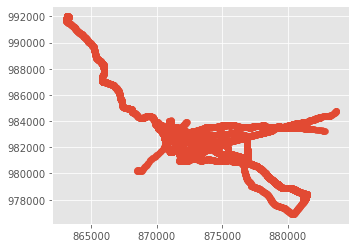

In [60]:
pico = pd.concat([car1, car3, car5, car7], axis = 0)
print(len(pico))
pico.plot()                  

110838


<AxesSubplot:>

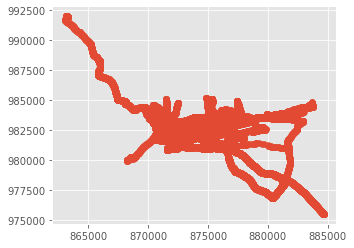

In [61]:
valle = pd.concat([car2, car4, car6, car8], axis = 0)
print(len(valle))
valle.plot()

In [62]:
#Se calculan los datos estadisticos de estas velocidades
#La media aritmética se define como la suma de N elementos dividida entre N.
mediapico = pico["velocity_k"].mean()
mediavalle = valle["velocity_k"].mean()
#La mediana es el valor que dentro del conjunto de datos es menor que el 50% de los datos y mayor que el 50% restante.
medianapico = pico["velocity_k"].median()
medianavalle = valle["velocity_k"].median()
#La desviación típica mide la dispersión de los datos respecto a la media
desvstdpico = pico["velocity_k"].std(ddof=0)
desvstdvalle = valle["velocity_k"].std(ddof=0)
varpico = pico["velocity_k"].var(ddof=0)
varvalle = valle["velocity_k"].var(ddof=0)


print("Media pico: ", mediapico)
print("Media valle: ", mediavalle)
print(" ")
print("Mediana pico: ", medianapico)
print("Mediana valle: ", medianavalle)
print(" ")
print("Desviasión estandar pico: ", desvstdpico)
print("Desviasión estandar valle: ", desvstdvalle)
print(" ")
print("Variancia pico: ", varpico)
print("Variancia valle: ", varvalle)

Media pico:  29.471989934144368
Media valle:  30.176193392931783
 
Mediana pico:  29.0
Mediana valle:  28.49414370387956
 
Desviasión estandar pico:  17.627500099390147
Desviasión estandar valle:  19.140208694493907
 
Variancia pico:  310.7287597539996
Variancia valle:  366.3475888687802


In [64]:
car1.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/pico1.shp")
car3.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/pico2.shp")
car5.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/pico3.shp")
car7.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/pico4.shp")

In [65]:
car2.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/valle1.shp")
car4.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/valle2.shp")
car6.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/valle3.shp")
car8.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/valle4.shp")